# CutMix and MixUp Augmentation using GPU/TPU
This notebook shows how perform cutmix and mixup data augmentation using the GPU/TPU with `TensorFlow.data.Dataset`. In our previous notebook [here][5], we demonstrated how to perform rotation, shear, zoom, and shift on GPU/TPU. Performing preprocess on GPU/TPU speeds up our training pipeline and allows us to experiment with more ideas quicker. Libraries like Nvidia DALI [here][1] help with GPU image preprocess and/or Nvidia RAPIDS [here][2] helps with GPU tabular preprocess.

## CutMix described [here][3]
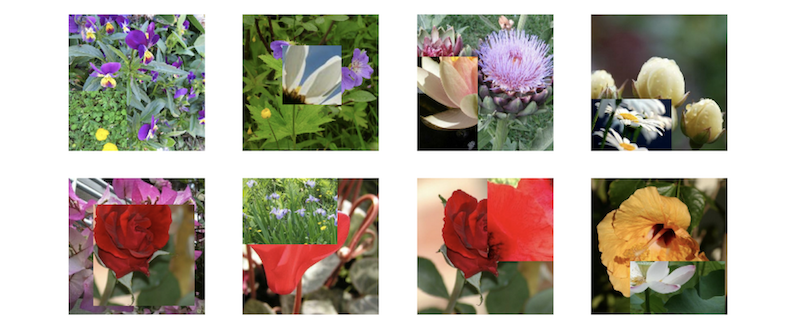
## MixUp described [here][4]
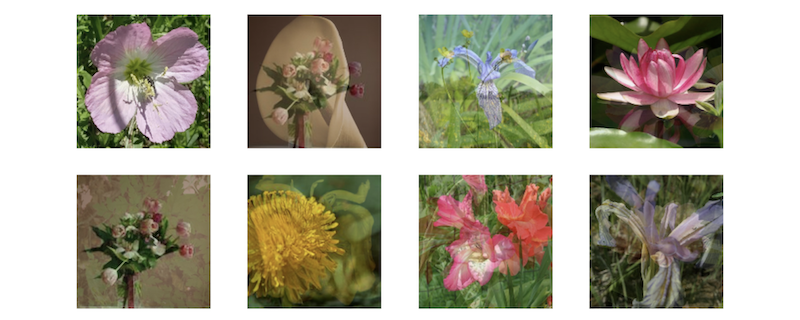

[1]: https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/index.html
[2]: https://developer.nvidia.com/rapids
[3]: https://arxiv.org/abs/1905.04899
[4]: https://arxiv.org/abs/1710.09412
[5]: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96

# Libraries and Configurations

In [ ]:
import random, re, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf, tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets
print('Tensorflow version ' + tf.__version__)
from sklearn.model_selection import KFold

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
IMAGE_SIZE = [512, 512]
EPOCHS = 25
FOLDS = 3
SEED = 777
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
AUG_BATCH = BATCH_SIZE
FIRST_FOLD_ONLY = False

# Mixed Precision and/or XLA
Mixed Precision and XLA are not being used in this notebook but you can experiment using them. Change the following booleans to enable mixed precision and/or XLA on GPU/TPU. By default TPU already uses some mixed precision but we can add more (and it already uses XLA). These allow the GPU/TPU memory to handle larger batch sizes and can speed up the training process. The Nvidia V100 GPU has special Tensor Cores which get utilized when mixed precision is enabled. Unfortunately Kaggle's Nvidia P100 GPU does not have Tensor Cores to receive speed up.

In [ ]:
MIXED_PRECISION = False
XLA_ACCELERATE = False

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

# Data Directories and Classes

In [ ]:
# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

In [ ]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Custom LR scheduler
From starter [kernel][1]

[1]: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu

In [ ]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Dataset Functions
From starter [kernel][1]

[1]: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset(dataset, do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.batch(AUG_BATCH)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO) # note we put AFTER batching
    dataset = dataset.unbatch()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset, do_onehot=True):
    dataset = dataset.batch(BATCH_SIZE)
    if do_onehot: dataset = dataset.map(onehot, num_parallel_calls=AUTO) # we must use one hot like augmented train data
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (1./FOLDS) )
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

# CutMix Augmentation
The following code does cutmix using the GPU/TPU. Change the variables `SWITCH`, `CUTMIX_PROB` and `MIXUP_PROB` in function `transform()` to control the amount of augmentation during training. CutMix will occur `SWITCH * CUTMIX_PROB` often and MixUp will occur `(1-SWITCH) * MIXUP_PROB` often during training.

In [ ]:
def onehot(image,label):
    CLASSES = 104
    return image,tf.one_hot(label,CLASSES)

In [ ]:
def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

# Display CutMix Augmentation

In [ ]:
row = 6; col = 4;
row = min(row,AUG_BATCH//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(AUG_BATCH).map(cutmix)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# MixUp Augmentation
The following code does mixup using the GPU/TPU. Change the variables `SWITCH`, `CUTMIX_PROB` and `MIXUP_PROB` in function `transform()` to control the amount of augmentation during training. CutMix will occur `SWITCH * CUTMIX_PROB` often and MixUp will occur `(1-SWITCH) * MIXUP_PROB` often during training.

In [ ]:
def mixup(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [ ]:
def transform(image,label):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    SWITCH = 0.5
    CUTMIX_PROB = 0.666
    MIXUP_PROB = 0.666
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image3, label3 = mixup(image, label, MIXUP_PROB)
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image4,label4

# Display MixUp Augmentation

In [ ]:
row = 6; col = 4;
row = min(row,AUG_BATCH//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(AUG_BATCH).map(mixup)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# Display 33%/33%/33% CutMix/MixUp/None
Change the variables `SWITCH`, `CUTMIX_PROB` and `MIXUP_PROB` in function `transform()` to control the amount of augmentation during training. CutMix will occur `SWITCH * CUTMIX_PROB` often and MixUp will occur `(1-SWITCH) * MIXUP_PROB` often. Currently `SWITCH=0.5`, `CUTMIX_PROB=0.666` and `MIXUP_PROB=0.666` resulting in 33% cutmix, 33% mixup, and 33% none during training.

In [ ]:
row = 6; col = 4;
row = min(row,AUG_BATCH//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(AUG_BATCH).map(transform)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# Build, Train, Infer Model
This is the 5-Fold workflow copied from Ragnar's notebook [here][1]. Now we add cutmix and/or mixup augmentation to the training images on the fly! Since cutmix and/or mixup returns one hot encoded labels, we change the loss and metric to `categorical_crossentropy` instead of `sparse_categorical_crossentropy`.

[1]: https://www.kaggle.com/ragnar123/5-kfold-densenet201

In [ ]:
from tensorflow.keras.applications import DenseNet201

def get_model():
    with strategy.scope():
        rnet = DenseNet201(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

def train_cross_validate(folds = 5):
    histories = []
    models = []
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
    kfold = KFold(folds, shuffle = True, random_state = SEED)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(TRAINING_FILENAMES)):
        print(); print('#'*25)
        print('### FOLD',f+1)
        print('#'*25)
        train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[trn_ind]['TRAINING_FILENAMES']), labeled = True)
        val_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_ind]['TRAINING_FILENAMES']), labeled = True, ordered = True)
        model = get_model()
        history = model.fit(
            get_training_dataset(train_dataset), 
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = EPOCHS,
            callbacks = [lr_callback],# early_stopping],
            validation_data = get_validation_dataset(val_dataset),
            verbose=2
        )
        models.append(model)
        histories.append(history)
        if FIRST_FOLD_ONLY: break
    return histories, models

def train_and_predict(folds = 5):
    test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
    test_images_ds = test_ds.map(lambda image, idnum: image)
    print('Start training %i folds'%folds)
    histories, models = train_cross_validate(folds = folds)
    print('Computing predictions...')
    # get the mean probability of the folds models
    if FIRST_FOLD_ONLY: probabilities = np.average([models[i].predict(test_images_ds) for i in range(1)], axis = 0)
    else: probabilities = np.average([models[i].predict(test_images_ds) for i in range(folds)], axis = 0)
    predictions = np.argmax(probabilities, axis=-1)
    print('Generating submission.csv file...')
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
    np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
    return histories, models
    
# run train and predict
histories, models = train_and_predict(folds = FOLDS)

# Confusion Matrix and Validation Score
Try forking and modifying this notebook to maximize validation score below. Tune the data augmentation and/or train for more epochs to increase accuracy. Good luck! (Code below is from starter [kernel][1]).

[1]: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu

In [ ]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

In [ ]:
%%time
all_labels = []; all_prob = []; all_pred = []
kfold = KFold(FOLDS, shuffle = True, random_state = SEED)
for j, (trn_ind, val_ind) in enumerate( kfold.split(TRAINING_FILENAMES) ):
    print('Inferring fold',j+1,'validation images...')
    VAL_FILES = list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_ind]['TRAINING_FILENAMES'])
    NUM_VALIDATION_IMAGES = count_data_items(VAL_FILES)
    cmdataset = get_validation_dataset(load_dataset(VAL_FILES, labeled = True, ordered = True), do_onehot=False)
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    all_labels.append( next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() ) # get everything as one batch
    prob = models[j].predict(images_ds)
    all_prob.append( prob )
    all_pred.append( np.argmax(prob, axis=-1) )
    if FIRST_FOLD_ONLY: break
cm_correct_labels = np.concatenate(all_labels)
cm_probabilities = np.concatenate(all_prob)
cm_predictions = np.concatenate(all_pred)

In [ ]:
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions); print()

In [ ]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall)); print()